**SEMINAR 4**

Jan Prats 213927 | Oscar Sanz 253613 | Julia Pérez 267029

**PART 1: DATA PREPARATION & ANALYSIS**

In [ ]:
from google.colab import drive
import pandas as pd


drive.mount('/content/drive')

#path oscar
base_path = '/content/drive/My Drive/TercerCurs/MLforNetworks/dataset_Seminar4'


train_path = f'{base_path}/train_data.csv'
test_path = f'{base_path}/test_data.csv'


#import the libraries we are going to use
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


1. Describe the statistics behind the main parameters of the dataset. For that, make use
 of the plots that you consider.

Training data statistics:
       LocationNumber          RSSI   TxLinkSpeed   RxLinkSpeed  \
count    33600.000000  33600.000000  33600.000000  33600.000000   
mean        18.151161    -62.364212    491.264874    460.954107   
std         10.338002      9.442463    240.868700    251.600115   
min          1.000000    -79.040000     33.240000    -12.530000   
25%          9.000000    -70.360000    273.200000    249.127500   
50%         18.000000    -62.910000    476.635000    396.480000   
75%         27.000000    -53.790000    664.390000    656.422500   
max         36.000000    -37.020000    905.390000    911.000000   

       MainAPConnect  TxThroughput  AvgPingLatency  
count   33600.000000  33600.000000    33600.000000  
mean        0.913958     12.988920       54.771372  
std         0.280430      4.413973        8.735672  
min         0.000000      0.780000       39.300000  
25%         1.000000     11.320000       48.940000  
50%         1.000000     14.790000       52.290000  

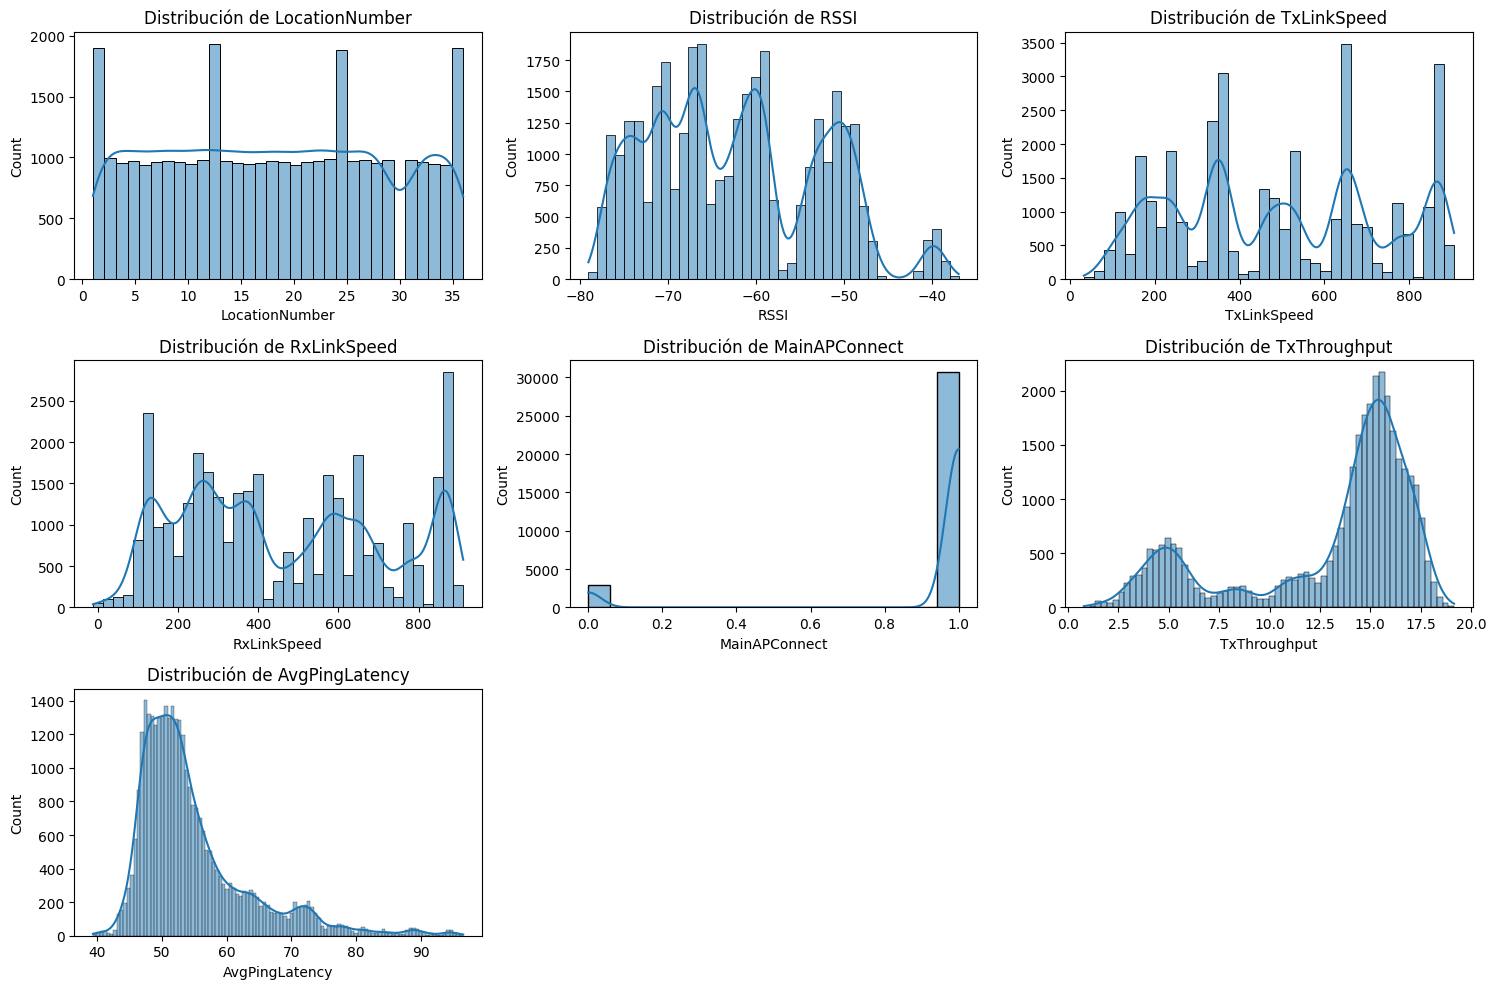

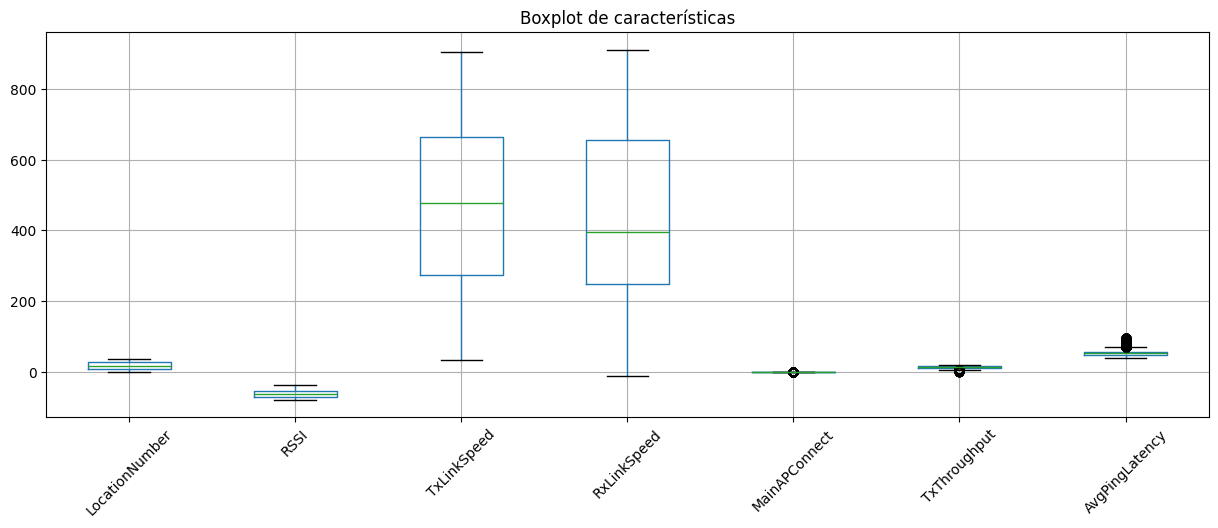

In [ ]:
#load training and test data
train_data = pd.read_csv(train_path)
test_data = pd.read_csv(test_path)

# Display descriptive statistics for training data
print("Training data statistics:")
print(train_data.describe())

# we define features for visualization
features = ['LocationNumber', 'RSSI', 'TxLinkSpeed', 'RxLinkSpeed', 'MainAPConnect', 'TxThroughput', 'AvgPingLatency']

plt.figure(figsize=(15, 10)) # Create histograms for each feature
for i, feature in enumerate(features, 1):
    plt.subplot(3, 3, i)
    sns.histplot(train_data[feature], kde=True)
    plt.title(f'Distribución de {feature}')
plt.tight_layout()
plt.show()

#Then, we visualize the plots
plt.figure(figsize=(15, 5))
train_data[features].boxplot()
plt.title('Boxplot de características')
plt.xticks(rotation=45)
plt.show()

2. Perform a correlation analysis between the main features in the dataset and the per
formance metrics (throughput and delay).

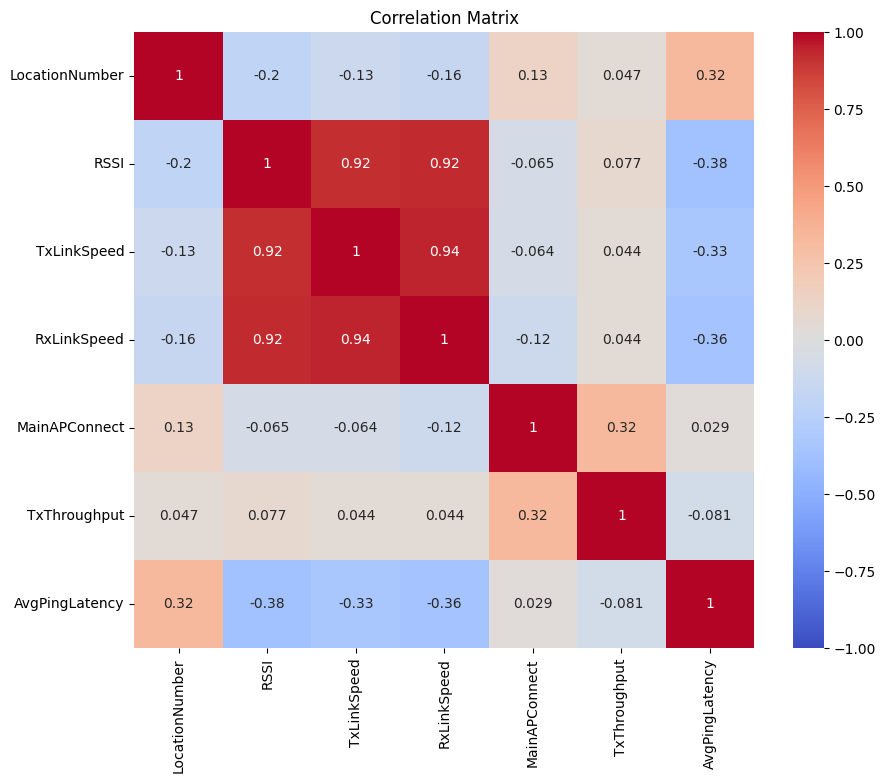

Correlations with TxThroughput:
TxThroughput      1.000000
MainAPConnect     0.321010
RSSI              0.076853
LocationNumber    0.046687
TxLinkSpeed       0.044451
RxLinkSpeed       0.044280
AvgPingLatency   -0.080901
Name: TxThroughput, dtype: float64

Correlations with AvgPingLatency:
AvgPingLatency    1.000000
LocationNumber    0.322541
MainAPConnect     0.028982
TxThroughput     -0.080901
TxLinkSpeed      -0.331170
RxLinkSpeed      -0.361945
RSSI             -0.375971
Name: AvgPingLatency, dtype: float64


In [ ]:
#Compute correlation matrix
correlation_matrix = train_data.corr()

#WE print a heatmap to visualize correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix')
plt.show()

#Print correlations with target metrics
print("Correlations with TxThroughput:")
print(correlation_matrix['TxThroughput'].sort_values(ascending=False))
print("\nCorrelations with AvgPingLatency:")
print(correlation_matrix['AvgPingLatency'].sort_values(ascending=False))

**PART 2: FNN-BASED PERFORMANCE PREDICTOR**

 1. Feature selection: select the features that you think will be most appropriate to
 predict Wi-Fi performance.

In [ ]:
!pip install torch

In [ ]:
features = ['RSSI', 'TxLinkSpeed', 'RxLinkSpeed', 'MainAPConnect']
#Why we choose this features?
#RSSI: Represents the intensity of the signal so its important to see if the signal is good enough
#TXLinkSpeed: is the velocity of the link when it goes down
#RxLinkSpeed: is the velocity of the link when it goes up
targets = ['TxThroughput', 'AvgPingLatency']  # we choose this two targets because the statement says to predict this metrics
X = train_data[features]
y = train_data[targets]

 2. Data preparation: apply the necessary data transformation techniques for your data
 (e.g., normalization, encoding).

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

#Normalize features and targets
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()
X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y)

#Split data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=42)

#Prepare test data
X_test = test_data[features]
y_test = test_data[targets]
X_test_scaled = scaler_X.transform(X_test)
y_test_scaled = scaler_y.transform(y_test)

#onvert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test_scaled, dtype=torch.float32)

#Create DataLoader for training and validation
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

 3. FNN architecture design: design your FNN and try to justify your choices (number
 of layers, input/output layers, activations, loss function, optimizer, regularization, etc.)
 according to the problem and data at hand.

In [ ]:
#Next, we define FNN architecture
class WiFiFNN(nn.Module):
    def __init__(self):
        super(WiFiFNN, self).__init__()
        self.layer1 = nn.Linear(4, 64)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(0.2)
        self.layer2 = nn.Linear(64, 32)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(0.2)
        self.output = nn.Linear(32, 2)

    def forward(self, x):
        x = self.layer1(x)
        x = self.relu1(x)
        x = self.dropout1(x)
        x = self.layer2(x)
        x = self.relu2(x)
        x = self.dropout2(x)
        x = self.output(x)
        return x

#Initialize model, loss function, and optimizer
model = WiFiFNN()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

 4. Train your FNN: use the training data to train your FNN. Describe your training
 approach (epochs, batches, validation) and show the training process (e.g., validation
 loss per epoch).

Epoch 1/100, Train Loss: 0.0314, Val Loss: 0.0312
Epoch 2/100, Train Loss: 0.0313, Val Loss: 0.0311
Stagnation detected: Loss change 0.000106 < 0.001000, Counter: 1/5
Epoch 3/100, Train Loss: 0.0314, Val Loss: 0.0310
Stagnation detected: Loss change 0.000062 < 0.001000, Counter: 2/5
Epoch 4/100, Train Loss: 0.0315, Val Loss: 0.0313
Stagnation detected: Loss change 0.000254 < 0.001000, Counter: 3/5
Epoch 5/100, Train Loss: 0.0313, Val Loss: 0.0312
Stagnation detected: Loss change 0.000120 < 0.001000, Counter: 4/5
Epoch 6/100, Train Loss: 0.0313, Val Loss: 0.0309
Stagnation detected: Loss change 0.000291 < 0.001000, Counter: 5/5
Training stopped due to stagnant validation loss


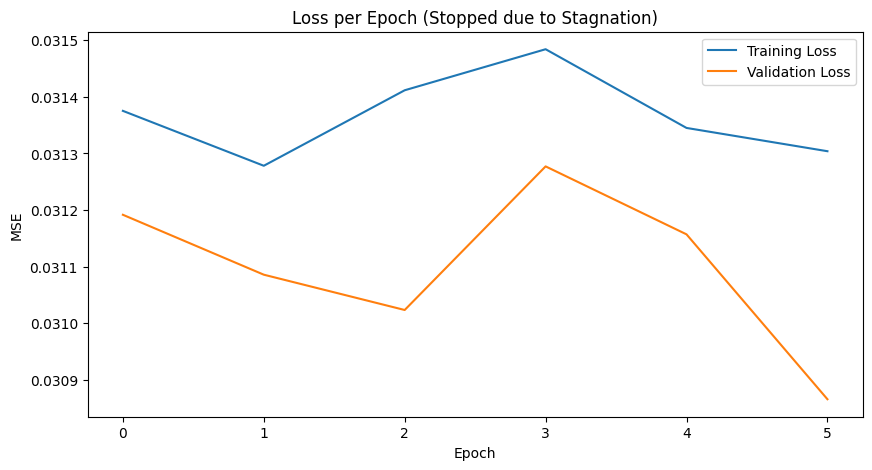

In [ ]:
#We are going to implement a condition to stop training when losses stagnate.
#If the Val loss is not greater than 0.001 in 5 times in a row, the train stops and print the plot

num_epochs = 100
stagnation_patience = 5 #number of times the simulation wait to stop
stagnation_threshold = 0.001  #Minimum change in validation loss to consider non-stagnant
best_val_loss = float('inf')
stagnation_counter = 0
train_losses = []
val_losses = []
prev_val_loss = None

for epoch in range(num_epochs):
    # Training phase
    model.train()
    train_loss = 0.0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * X_batch.size(0)
    train_loss /= len(train_loader.dataset)
    train_losses.append(train_loss)

    # Validation phase
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            val_loss += loss.item() * X_batch.size(0)
        val_loss /= len(val_loader.dataset)
        val_losses.append(val_loss)

    #Print progress
    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')

    #save best model
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), f'{base_path}/best_model.pth')

    #Check for stagnation
    if prev_val_loss is not None:
        loss_change = abs(prev_val_loss - val_loss)
        if loss_change < stagnation_threshold:
            stagnation_counter += 1
            print(f"Stagnation detected: Loss change {loss_change:.6f} < {stagnation_threshold:.6f}, Counter: {stagnation_counter}/{stagnation_patience}")
            if stagnation_counter >= stagnation_patience:
                print("Training stopped due to stagnant validation loss")
                #Plot training and validation loss immediately
                plt.figure(figsize=(10, 5))
                plt.plot(train_losses, label='Training Loss')
                plt.plot(val_losses, label='Validation Loss')
                plt.title('Loss per Epoch (Stopped due to Stagnation)')
                plt.xlabel('Epoch')
                plt.ylabel('MSE')
                plt.legend()
                plt.savefig(f'{base_path}/training_loss_pytorch.png')
                plt.show()
                break
        else:
            stagnation_counter = 0  # Reset counter if loss changes significantly
    prev_val_loss = val_loss

#Load best model if training completed or was stopped
model.load_state_dict(torch.load(f'{base_path}/best_model.pth'))

#Plot training and validation loss if not already plotted
if stagnation_counter < stagnation_patience:  # Plot only if not stopped early
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title('Loss per Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('MSE')
    plt.legend()
    plt.show()


 5. Evaluate your FNN:evaluateyoursolution using the test data and report the results.

Test Loss (MSE): 0.0305
Test MAE: 0.1275


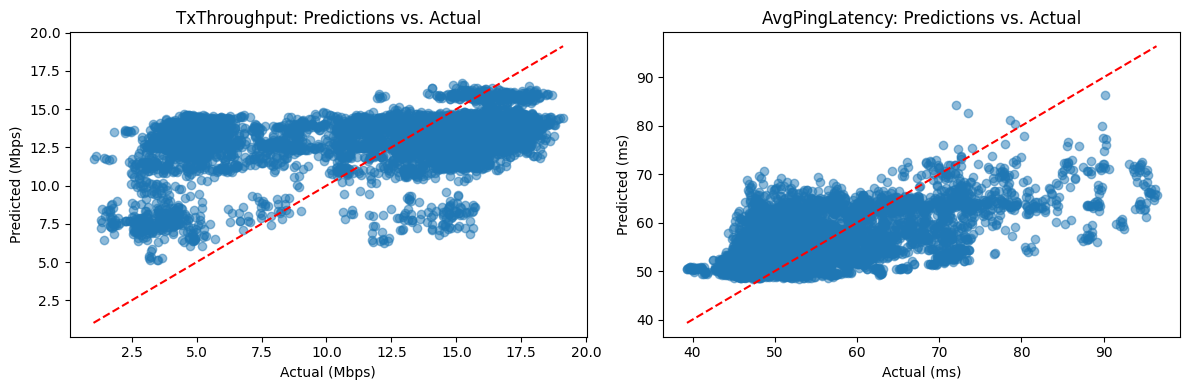

In [ ]:
#evaluate model on test data
model.eval()
with torch.no_grad():
    y_pred_scaled = model(X_test_tensor)
    test_loss = criterion(y_pred_scaled, y_test_tensor).item()
    #compute MAE
    mae = torch.mean(torch.abs(y_pred_scaled - y_test_tensor)).item()
print(f"Test Loss (MSE): {test_loss:.4f}")
print(f"Test MAE: {mae:.4f}")

#unscale predictions and actual values
y_pred_scaled = y_pred_scaled.numpy()
y_test = y_test_tensor.numpy()
y_pred = scaler_y.inverse_transform(y_pred_scaled)
y_test = scaler_y.inverse_transform(y_test)

#plot predictions vs. actual values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.scatter(y_test[:, 0], y_pred[:, 0], alpha=0.5)
plt.plot([y_test[:, 0].min(), y_test[:, 0].max()], [y_test[:, 0].min(), y_test[:, 0].max()], 'r--')
plt.title('TxThroughput: Predictions vs. Actual')
plt.xlabel('Actual (Mbps)')
plt.ylabel('Predicted (Mbps)')

plt.subplot(1, 2, 2)
plt.scatter(y_test[:, 1], y_pred[:, 1], alpha=0.5)
plt.plot([y_test[:, 1].min(), y_test[:, 1].max()], [y_test[:, 1].min(), y_test[:, 1].max()], 'r--')
plt.title('AvgPingLatency: Predictions vs. Actual')
plt.xlabel('Actual (ms)')
plt.ylabel('Predicted (ms)')
plt.tight_layout()
plt.show()

The training successfully predicts Wi-Fi performance (as specified in the statement: TxThroughput and AvgPingLatency) with an average error of approximately 2.57 Mbps and 6.42 ms, respectively. This indicates that the predictions are reasonably accurate for a general analysis but not optimal for applications requiring high precision.

The values at the extremes (which are somewhat scattered) in the graphs suggest that the model struggles with outlier data or extreme network conditions. Apart from this, we believe that the consistency between the two predictions, TxThroughput and AvgPingLatency, indicates that the FNN architecture is suitable for the problem. However, if we aim to use it for more critical and specific applications, it would not be as accurate.